# Linear Algebra & Calculus for Quantitative Finance

## Lesson 1.3: Mathematical Foundations

This notebook covers the essential linear algebra and calculus concepts needed for quantitative finance.

### Topics Covered:
- Vector operations and matrix algebra
- Eigenvalues and eigenvectors
- Partial derivatives and gradients
- Optimization techniques
- Applications in portfolio theory and risk management


In [1]:
# setup and imports

%pip install pandas_datareader pandas numpy matplotlib scipy statsmodels

import warnings, math
warnings.filterwarnings("ignore")

# numerics
import numpy as np                   # fast arrays, linear algebra (dot products, eigendecomp)
import pandas as pd                  # tabular data (like Excel), time series handling

# plotting
import matplotlib.pyplot as plt      # charts (histograms, scree plots, etc.)
plt.rcParams["figure.figsize"] = (9,5)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

# stats and optimization
from scipy import stats              # PDFs/CDFs, random draws, tests
from scipy.optimize import minimize  # constrained optimization (SLSQP)
from pandas_datareader import data as web  # Stooq access through pandas-datareader

np.random.seed(42)  # reproducibility of random draws


Note: you may need to restart the kernel to use updated packages.


In [4]:
# price data from stooq

TICKERS = ["SPY", "QQQ", "TLT", "GLD"] # equities, tech, long treasuries bond, gold

def fetch_stooq_close(tkr, start=None, end=None):
    df = web.DataReader(tkr, "stooq", start=start, end=end) # daily OHLC
    s = df["Close"].sort_index().rename(tkr)
    return s

# pull and join
prices = pd.concat([fetch_stooq_close(t) for t in TICKERS], axis=1).dropna()
prices.tail()

,SPY,QQQ,TLT,GLD
Date,,,,
2025-09-29,663.68,598.73,89.63,352.46
2025-09-30,666.18,600.37,89.37,355.47
2025-10-01,668.45,603.25,89.29,356.03
2025-10-02,669.22,605.73,89.55,354.79
2025-10-03,669.21,603.18,89.38,357.64


In [5]:
# daily log returns (additive property over time)
R = np.log(prices/prices.shift(1)).dropna()
R.describe().T

,count,mean,std,min,25%,50%,75%,max
SPY,1254.0,0.000603,0.010842,-0.060327,-0.004516,0.000746,0.006356,0.099863
QQQ,1254.0,0.000648,0.014343,-0.064121,-0.006573,0.001153,0.008489,0.113356
TLT,1254.0,-0.000362,0.010191,-0.034730,-0.007136,-0.000324,0.006126,0.037749
GLD,1254.0,0.000560,0.009492,-0.045281,-0.004664,0.000554,0.005964,0.036324


In [6]:
# matrices & vectors. Portfolio mean/variance

# sample equal weights for illustration
w_eq = np.repeat(1/len(R.columns), len(R.columns))
w_eq = pd.Series(w_eq, index=R.columns, name="weight")

# estimate mean vector (μ) and covariance matrix (Σ) from historical returns
mu = R.mean()                 # vector (per-day average log return)
Sigma = R.cov()               # covariance matrix (symmetric, PSD)

# Portfolio mean and variance using linear algebra:
# mean:    μ_p = w^T μ
# variance:σ_p^2 = w^T Σ w
mu_p = float(w_eq @ mu)
var_p = float(w_eq @ Sigma @ w_eq)
vol_p = math.sqrt(var_p) # volatility is described as standard deviation

pd.Series({
    "mu_p_daily": mu_p,
    "vol_p_daily": vol_p,
    "mu_p_annual": 252*mu_p,
    "vol_p_annual": np.sqrt(252)*vol_p
}).round(6)


mu_p_daily      0.000362
vol_p_daily     0.007725
mu_p_annual     0.091258
vol_p_annual    0.122627
dtype: float64

In [7]:
# eigenvalues and eigenvectors: principal componenet analysis (PCA) of covariance

# for symmetric covariance matrices, use eigh (more stable for Hermitian matrices)
eigvals, eigvecs = np.linalg.eigh(Sigma.values)   # returns ascending eigenvalues
# sort descending by eigenvalue (variance explained)
idx = eigvals.argsort()[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# variance explained by each principal component
var_explained = eigvals / eigvals.sum()
pc_labels = [f"PC{i+1}" for i in range(len(eigvals))]
pd.Series(var_explained, index=pc_labels).round(4)




PC1    0.6136
PC2    0.2323
PC3    0.1369
PC4    0.0172
dtype: float64

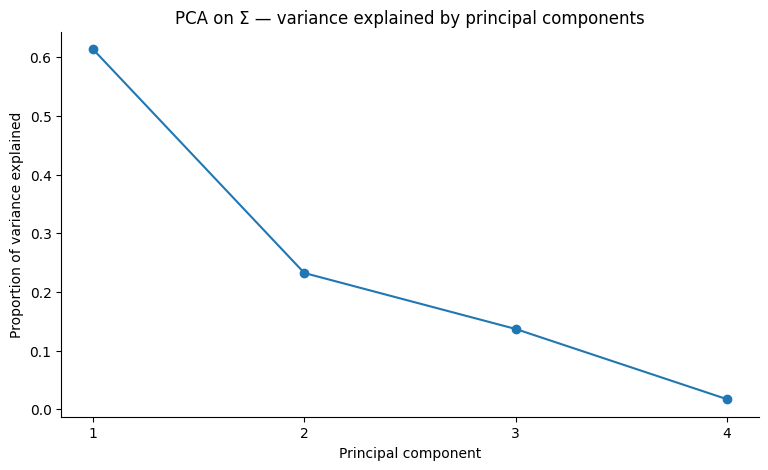

SPY   -0.591416
QQQ   -0.796837
TLT   -0.075467
GLD   -0.097889
Name: PC1_loadings, dtype: float64

In [8]:
# scree plot: how much variance each PC explains (risk factors)
plt.figure()
plt.plot(range(1, len(eigvals)+1), var_explained, marker="o")
plt.title("PCA on Σ — variance explained by principal components")
plt.xlabel("Principal component")
plt.ylabel("Proportion of variance explained")
plt.xticks(range(1, len(eigvals)+1)); plt.show()

# loadings of the first PC (the "market mode" often)
pc1_loadings = pd.Series(eigvecs[:,0], index=R.columns, name="PC1_loadings")
pc1_loadings


In [9]:
# optimization: long-only minimum-variance portfolio
# goal: quadratic in w
# constraints: fully invested, no shorting
    
n = len(R.columns)
Sigma_np = Sigma.values

def portfolio_var(w, Sigma=Sigma_np):
    # objective: 0.5 * w^T Σ w (0.5 is optional; doesn't change argmin)
    return 0.5 * float(w.T @ Sigma @ w)

def weight_sum_constraint(w):
    return np.sum(w) - 1.0     # = 0 at optimum

# Bounds: 0 <= w_i <= 1  (long-only)
bounds = [(0.0, 1.0)] * n
cons = ({"type":"eq", "fun": weight_sum_constraint},)

w0 = np.repeat(1/n, n)  # start at equal weights
res = minimize(portfolio_var, w0, method="SLSQP", bounds=bounds, constraints=cons,
               options={"ftol":1e-12, "maxiter":10_000})

w_minvar = pd.Series(res.x, index=R.columns, name="w_minvar")
var_min = float(w_minvar @ Sigma @ w_minvar)
vol_min = math.sqrt(var_min)

display(w_minvar.round(4))
print({"vol_min_daily": vol_min, "vol_min_annual": np.sqrt(252)*vol_min})


SPY    0.3213
QQQ    0.0000
TLT    0.3210
GLD    0.3577
Name: w_minvar, dtype: float64

{'vol_min_daily': 0.006657099871803944, 'vol_min_annual': 0.10567818428227922}


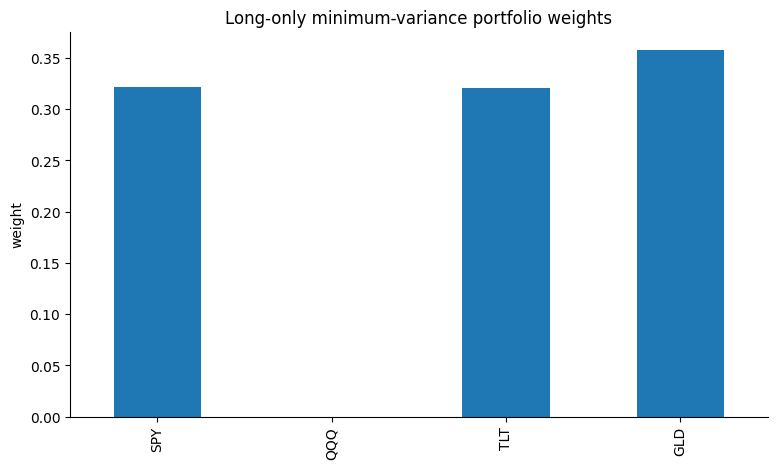

In [11]:
# visualize weights
plt.figure()
w_minvar.plot(kind="bar")
plt.title("Long-only minimum-variance portfolio weights")
plt.ylabel("weight"); plt.show()


In [12]:
# multivariable calc: gradients and hessians

def grad_var(w, Sigma=Sigma_np):
    # analytic gradient (Σ w)
    return Sigma @ w

def numeric_grad(f, w, eps=1e-6):
    # central differences for each coordinate
    g = np.zeros_like(w)
    for i in range(len(w)):
        step = np.zeros_like(w); step[i] = eps
        g[i] = (f(w+step) - f(w-step)) / (2*eps)
    return g

w_test = w_minvar.values  # evaluate gradient at the min-var solution
g_anal = grad_var(w_test)
g_num  = numeric_grad(lambda x: portfolio_var(x, Sigma_np), w_test)

pd.DataFrame({"grad_analytic": g_anal, "grad_numeric": g_num}, index=R.columns).round(6)


,grad_analytic,grad_numeric
SPY,0.000044,0.000044
QQQ,0.000057,0.000057
TLT,0.000044,0.000044
GLD,0.000044,0.000044


In [13]:
# Hessian check: should be Σ itself
H_expected = Sigma_np
# quick numeric Hessian along a few random directions (optional sanity)
def directional_second_derivative(f, w, v, eps=1e-5):
    # approx v^T H v by finite differences of directional derivative
    return (f(w+eps*v) - 2*f(w) + f(w-eps*v)) / (eps**2)

for _ in range(3):
    v = np.random.randn(n); v /= np.linalg.norm(v)
    dd_num = directional_second_derivative(lambda x: portfolio_var(x, Sigma_np), w_test, v)
    dd_true = float(v.T @ H_expected @ v) * 0.5  # note our f has 0.5 factor
    print({"v^T H v (numeric)": dd_num, "v^T Σ v * 0.5 (true)": dd_true})


{'v^T H v (numeric)': 0.00010945518986614151, 'v^T Σ v * 0.5 (true)': 5.472758538698891e-05}
{'v^T H v (numeric)': 0.00011971916242647233, 'v^T Σ v * 0.5 (true)': 5.985960237162119e-05}
{'v^T H v (numeric)': 6.18024376250123e-05, 'v^T Σ v * 0.5 (true)': 3.090126343052633e-05}


In [14]:
# numerical linear algebra: cholesky and monte carlo

# Cholesky factor (lower-triangular), stable for SPD matrices
L = np.linalg.cholesky(Sigma_np)

def simulate_portfolio_logret(B=100_000, horizon=1, w=w_minvar.values, mu=mu.values, L=L):
    """
    Monte Carlo of horizon-day log returns for the given weights.
    We draw N(0, I), transform by L to impose covariance, then add mean vector.
    """
    n = len(mu)
    # Draws: shape (B, horizon, n)
    Z = np.random.randn(B, horizon, n)
    # Apply covariance via L, add mean each day, then project to portfolio
    R_draws = (Z @ L.T) + mu   # (B, horizon, n)
    r_path = R_draws @ w       # (B, horizon)
    return r_path.sum(axis=1)  # horizon sum of log-returns

r1 = simulate_portfolio_logret(B=100_000, horizon=1)
r21 = simulate_portfolio_logret(B=100_000, horizon=21)

def var_es(samples, alpha=0.01):
    q = np.quantile(samples, alpha)
    es = samples[samples <= q].mean()
    return q, es

rows = []
for label, x in [("1d", r1), ("21d", r21)]:
    for a in (0.05, 0.01):
        VaR, ES = var_es(x, alpha=a)
        rows.append({"horizon": label, "alpha": a, "VaR": VaR, "ES": ES})
pd.DataFrame(rows)


,horizon,alpha,VaR,ES
0,1d,0.05,-0.010591,-0.013373
1,1d,0.01,-0.015190,-0.017472
2,21d,0.05,-0.044317,-0.056956
3,21d,0.01,-0.064594,-0.075364


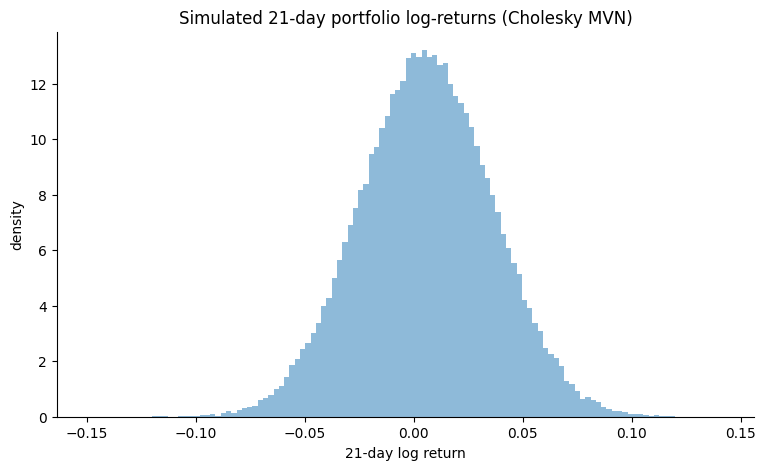

In [15]:
# visualize distribution of 21-day simulated portfolio log-returns
plt.figure()
plt.hist(r21, bins=120, density=True, alpha=0.5)
plt.title("Simulated 21-day portfolio log-returns (Cholesky MVN)")
plt.xlabel("21-day log return"); plt.ylabel("density"); plt.show()


In [ ]:
"""
1. diversification and the covariance matrix

The equation iself represents portfolio risk and sums up each 
assets volatility and the way the assets correlate with eachother.
The cross term is big and positive. With a correlation of 0.8 
which is high, you can assume that as one asset spikes so will 
the other one, which means risk is higher and you should likely 
diversify your portfolio more or lower your position size. Where 
if the correlation is low ~0, then the two assets do not typically
move together and holding both is a lower risk and you could 
increase position size.

2. principal component analysis (PCA) in risk management

If the principal component analysis on variance, shows that
principal component 1 explains 65-75% of variance (alot) and
its loadings are all positive and similar across equities. We
know that a single market-wide factor is driving most of the
movement. To manage this you can hedge the market factor with
an index future or ETF short, cap your portfolio's exposure to
PC1 in your risk budget or add assets that don't load heavily on
that factor. The main limit is instability, PCA depends on the
sample window. Factors and loadings can shift when regime change,
volatility spikes, or sectors rotate. So re-estimating regularly
is important.


"""